In [1]:
%pip install --upgrade tensorflow

  Using cached tensorflow-2.9.1-cp37-cp37m-win_amd64.whl (444.0 MB)
  Using cached tensorflow-2.9.0-cp37-cp37m-win_amd64.whl (444.0 MB)



You should consider upgrading via the 'c:\Users\kosta\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import tensorflow

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
import csv
PositiveImagePaths = []
NegativeImagePaths = []


with open("MURA-v1.1/valid_image_paths.csv", "r") as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        if "positive" in row[0].split("/")[4]:
          PositiveImagePaths.append(row[0])
        else : NegativeImagePaths.append(row[0])
            
print(len(PositiveImagePaths))
print(len(NegativeImagePaths))


import shutil
count = 0

for x in PositiveImagePaths:
    count = count + 1
    with open(x, 'rb') as fin:
        with open("MURA-2folder/valid/positive/"+str(count)+".png", 'wb') as fout:
            shutil.copyfileobj(fin, fout, 2048*1024)

print(count)
count = 0

for x in NegativeImagePaths:
    count = count + 1
    with open(x, 'rb') as fin:
        with open("MURA-2folder/valid/negative/"+str(count)+".png", 'wb') as fout:
            shutil.copyfileobj(fin, fout, 2048*1024)
            
print(count)

1530
1667
1530
1667


In [4]:
import csv
PositiveImagePaths = []
NegativeImagePaths = []


with open("MURA-v1.1/train_image_paths.csv", "r") as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        if "positive" in row[0].split("/")[4]:
          PositiveImagePaths.append(row[0])
        else : NegativeImagePaths.append(row[0])
            
print(len(PositiveImagePaths))
print(len(NegativeImagePaths))


import shutil
count = 0

for x in PositiveImagePaths:
    count = count + 1
    with open(x, 'rb') as fin:
        with open("MURA-2folder/train/positive/"+str(count)+".png", 'wb') as fout:
            shutil.copyfileobj(fin, fout, 2048*1024)

print(count)
count = 0

for x in NegativeImagePaths:
    count = count + 1
    with open(x, 'rb') as fin:
        with open("MURA-2folder/train/negative/"+str(count)+".png", 'wb') as fout:
            shutil.copyfileobj(fin, fout, 2048*1024)
            
print(count)

14873
21935
14873
21935


In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

trainDs = image_dataset_from_directory("MURA-2folder/train",
                            labels='inferred',
                            label_mode='binary',
                            color_mode='grayscale',
                            validation_split=0.4,
                            subset="training",
                            batch_size=1,
                            image_size=(224, 224),
                            seed=123
                            )

#testDs used as TEST dataset
testDs = image_dataset_from_directory("MURA-2folder/train",
                            labels='inferred',
                            label_mode='binary',
                            color_mode='grayscale',
                            validation_split=0.4,
                            subset="validation",
                            batch_size=1,
                            image_size=(224, 224),
                            seed=123
                            )


validDs = image_dataset_from_directory("MURA-2folder/valid",
                            labels='inferred',
                            label_mode='binary',
                            color_mode='grayscale',
                            batch_size=1,
                            image_size=(224, 224),
                            seed=123
                            )

print(trainDs)
print(trainDs.class_names)

Found 36808 files belonging to 2 classes.
Using 22085 files for training.
Found 36808 files belonging to 2 classes.
Using 14723 files for validation.
Found 3197 files belonging to 2 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
['negative', 'positive']


In [6]:
print(len(trainDs.take(1)))

1


In [7]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras import Model

MobileNetV2 = MobileNetV2(weights='imagenet',include_top= 'false') 

#Added below layers cause our images are greyscale (224,224,1)
input_tensor = Input(shape=(224,224,1) )
img_conc = Concatenate()([input_tensor, input_tensor, input_tensor])       # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
out = MobileNetV2(img_conc) 

base_model = Model(inputs=input_tensor,outputs=out)

print(base_model.layers)
base_model.trainable = False


[<keras.engine.input_layer.InputLayer object at 0x0000014BEF96D248>, <keras.layers.merging.concatenate.Concatenate object at 0x0000014B99163908>, <keras.engine.functional.Functional object at 0x0000014B99173E48>]


In [8]:
%pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\kosta\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [9]:
import keras_tuner as kt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import BinaryCrossentropy 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import numpy as np


def model_builder(hp):
  model = Sequential()

  model.add(base_model)
  # Αdd a hidden MLP layer
  for i in range(hp.Int('mlp_hidden_layers', 1, 3)):
    hp_dropout = hp.Choice('dropout_rate1_' + str(i), values=[0.3, 0.4, 0.5])
    model.add(Dropout(hp_dropout))
    hp_dense = hp.Choice('DENSE_units_' + str(i), values=[int(512/(i+1)), int(256/(i+1)), int(128/(i+1))])
    model.add(Dense(hp_dense, activation='relu' ))

  # Αdd the output MLP layer
  hp_dropout = hp.Choice('dropout_rate2', values=[0.3, 0.4, 0.5])
  model.add(Dropout(hp_dropout))
  model.add(Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[2e-3, 1e-3, 9e-4])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=BinaryCrossentropy(),
                metrics=['accuracy', 'cosine_proximity'])

  return model

tuner = kt.BayesianOptimization(model_builder,
                    objective='val_accuracy',
                    max_trials=5,
                    overwrite=True,
                    )

tuner.search_space_summary()

stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=2, 
                                              min_delta=0.001,
                                              mode='auto')

tuner.search(trainDs.take(1600), 
             batch_size=32,
             epochs=5, 
             callbacks=[stop_early],
             validation_data=validDs.take(200)
             )

best_model = tuner.get_best_models()[0]

best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(best_hyperparameters.values)

Trial 5 Complete [00h 04m 25s]
val_accuracy: 0.5400000214576721

Best val_accuracy So Far: 0.6050000190734863
Total elapsed time: 00h 27m 41s
INFO:tensorflow:Oracle triggered exit


{'mlp_hidden_layers': 2, 'dropout_rate1_0': 0.5, 'DENSE_units_0': 512, 'dropout_rate2': 0.5, 'learning_rate': 0.0009, 'dropout_rate1_1': 0.4, 'DENSE_units_1': 256, 'dropout_rate1_2': 0.4, 'DENSE_units_2': 170}


In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import BinaryCrossentropy 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import numpy as np

# {'mlp_hidden_layers': 2, 'dropout_rate1_0': 0.5, 'DENSE_units_0': 512, 'dropout_rate2': 0.5,
#  'learning_rate': 0.0009, 'dropout_rate1_1': 0.4, 'DENSE_units_1': 256, ######'dropout_rate1_2': 0.4, 'DENSE_units_2': 170


model = Sequential()

model.add(base_model)

# Αdd MLP layers
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu' ))

model.add(Dropout(0.4))
model.add(Dense(256, activation='relu' ))

# Αdd the output MLP layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0009),
            loss=BinaryCrossentropy(),
            metrics=['accuracy', 'cosine_proximity'])

print(model.summary())

checkpoint = ModelCheckpoint(
    'checkpoints/weights',
    monitor='val_accuracy', 
    mode='auto', 
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )

early_stopping = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.0001,
   patience=3,
   verbose=2,
   mode='auto',
   )

history = model.fit(
    trainDs,
    validation_data=validDs, 
    batch_size=32,
    epochs=10,
    shuffle=True,
    callbacks=[checkpoint, early_stopping]
    )

model.save('model')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1000)              3538984   
                                                                 
 dropout_5 (Dropout)         (None, 1000)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               512512    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

KeyboardInterrupt: 

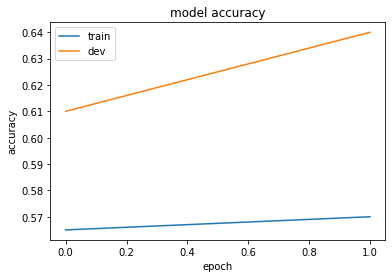

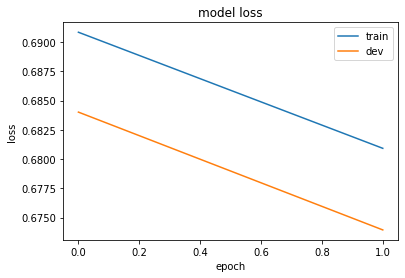

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def loss_curve(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'dev'], loc='upper left')
  plt.show()
  
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'dev'], loc='upper right')
  plt.show()


loss_curve(history)

In [ ]:
#scores
from sklearn.metrics import f1_score,precision_score,recall_score,precision_recall_curve,auc,average_precision_score
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

#All needed scores to be calaculated for each estimator later
def scores(y, predictions, probs, soft_pred=None) :
  score = precision_score(y, predictions,pos_label=0)
  print("Negative class precision: {:.2f}%".format(score*100))
  score = precision_score(y, predictions,pos_label=1)
  print("Positive class precision: {:.2f}%".format(score*100))
  score = recall_score(y, predictions,pos_label=0)
  print("Negative class recall: {:.2f}%".format(score*100))
  score = recall_score(y, predictions,pos_label=1)
  print("Positive class recall: {:.2f}%".format(score*100))
  score = f1_score(y,predictions,pos_label=0)
  print("Negative class f1-score: {:.2f}%".format(score*100))
  score = f1_score(y,predictions,pos_label=1)
  print("Positive class f1-score: {:.2f}%".format(score*100))

  print("--- MACRO-AVERAGED RESULTS ---\n")
  #MACRO
  score = precision_score(y, predictions, average='macro')
  print("macro-precision: {:.2f}%".format(score*100))
  score = recall_score(y, predictions, average='macro')
  print("macro-recall: {:.2f}%".format(score*100))
  score = f1_score(y,predictions, average='macro')
  print("macro-f1-score: {:.2f}%".format(score*100))
  
  
def predict_results(dataSetToTest) :
    #PREDICTIONS
    probs = model.predict(dataSetToTest)
    
    #print(probs)
    
    preds_01 = []
    for p in probs:
        if p > 0.5:
            preds_01.append(1)
        else : preds_01.append(0)
        
    #print(preds_01)

    #REAL Y
    real_y = []
    for bX, by in dataSetToTest: 
        real_y.append(int(by))

    #print(real_y)

    scores(real_y,preds_01,probs)

In [ ]:
#TRAIN
print('Training results:')
predict_results(trainDs)

#VALID / DEVELOPMENT
print('Development results:')
predict_results(validDs)

#TEST
print('Test results:')
predict_results(testDs)

Training results:
   88/22085 [..............................] - ETA: 14:11

KeyboardInterrupt: 